In [399]:
from optuna.integration.lightgbm import lgb
import pandas as pd
import numpy as np
import optuna
import shap
import pickle
import os
from tqdm import tqdm
import warnings
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit as tss
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [400]:
start_date = '2023-7-1'
end_date = '2023-7-31'

In [401]:
df = pd.read_csv('train_merged.csv')
ignore_features_reg = ['end_code', 'start_code', 'KP', 'is_congestion', 'holiday', 'search_specified_same_day_hour_mean', 'search_unspecified_same_day_mean', 'OCC_hour_move_ave_7d']
categorical_features = ['day_of_week', 'section', 'n_of_holidays']
df['datetime'] = pd.to_datetime(df['datetime'])

# sample_weightに入れる重みを計算
coef_0 = 1
coef_1 = 100

weight_reg = compute_sample_weight(class_weight='balanced', y=df['speed_tomorrow'])
weight_df = pd.DataFrame()
weight_df['speed_tomorrow'] = df['speed_tomorrow']
weight_df['weight_reg'] = weight_reg
weight_df.loc[weight_df['speed_tomorrow'] > 40, 'weight_reg'] = (weight_df[weight_df['speed_tomorrow'] > 40]['weight_reg'] * coef_0).set_axis(weight_df.loc[weight_df['speed_tomorrow'] > 40].index)
weight_df.loc[weight_df['speed_tomorrow'] <= 40, 'weight_reg'] = (weight_df[weight_df['speed_tomorrow'] <= 40]['weight_reg'] * coef_1).set_axis(weight_df.loc[weight_df['speed_tomorrow'] <= 40].index)
df['weight_reg'] = weight_df['weight_reg']

df_train = df[df['datetime'] < start_date+' 00:00:00']
df_train = df_train[df_train['tomorrow_holiday'] == 1]
df_test = df[(df['datetime'] >= start_date+' 00:00:00') & (df['datetime'] <= end_date+' 23:00:00')]


In [402]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

folds = tss(n_splits=5)

test_x_reg = df_test.drop(['speed_tomorrow', 'is_congestion_tomorrow', 'tomorrow_holiday', 'weight_reg', *ignore_features_reg], axis=1)
test_y_reg = df_test['speed_tomorrow']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 305435, number of used features: 16
[LightGBM] [Info] Start training from score 61.192388
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	Train's rmse: 13.4739	Test's rmse: 22.6056


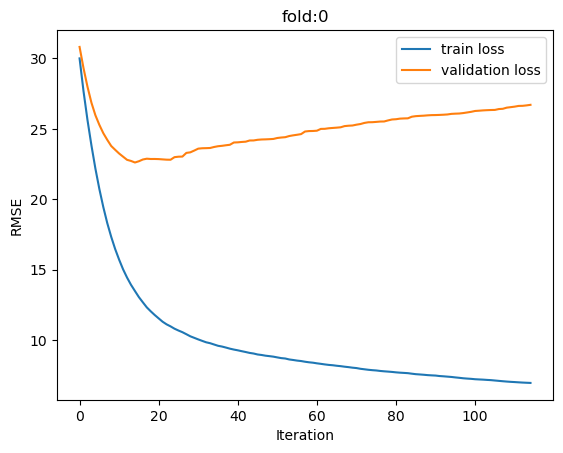

100%|██████████| 30/30 [00:00<00:00, 383.69it/s]


Fold 0:
TN  FP
FN  TP
[[204375    681]
 [   746     77]]
Accuracy: 0.9930687442624065
Recall: 0.09356014580801944
Precision: 0.10158311345646438
F1 score : 0.09740670461733081
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3109
[LightGBM] [Info] Number of data points in the train set: 610866, number of used features: 16
[LightGBM] [Info] Start training from score 56.833594
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	Train's rmse: 11.5379	Test's rmse: 18.3986


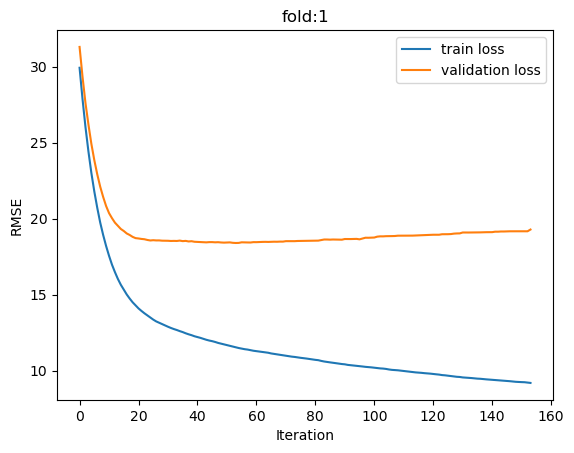

100%|██████████| 30/30 [00:00<00:00, 236.41it/s]


Fold 1:
TN  FP
FN  TP
[[203180   1876]
 [   510    313]]
Accuracy: 0.988410668402314
Recall: 0.38031591737545567
Precision: 0.14298766560073092
F1 score : 0.20783532536520583
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3140
[LightGBM] [Info] Number of data points in the train set: 916297, number of used features: 16
[LightGBM] [Info] Start training from score 58.826442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	Train's rmse: 13.523	Test's rmse: 19.4254


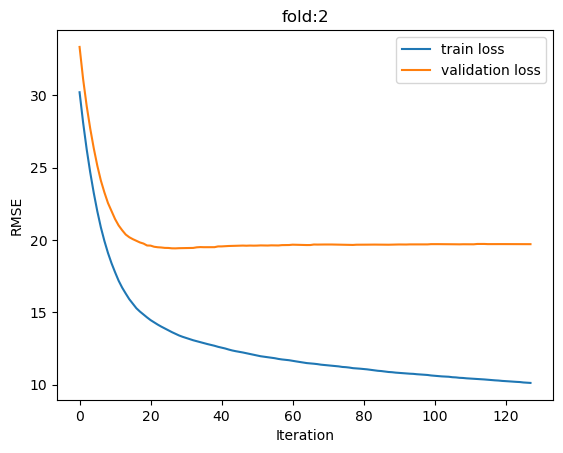

100%|██████████| 30/30 [00:00<00:00, 300.63it/s]


Fold 2:
TN  FP
FN  TP
[[201085   3971]
 [   394    429]]
Accuracy: 0.9787982261425401
Recall: 0.5212636695018226
Precision: 0.0975
F1 score : 0.1642734060884549
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3248
[LightGBM] [Info] Number of data points in the train set: 1221728, number of used features: 16
[LightGBM] [Info] Start training from score 62.008668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	Train's rmse: 13.7657	Test's rmse: 20.1997


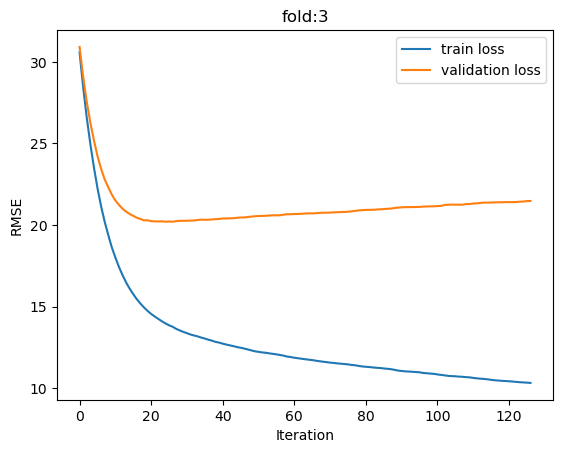

100%|██████████| 30/30 [00:00<00:00, 284.49it/s]


Fold 3:
TN  FP
FN  TP
[[201924   3132]
 [   386    437]]
Accuracy: 0.9829122931430597
Recall: 0.5309842041312273
Precision: 0.12244326141776408
F1 score : 0.19899817850637525
---------------------------------------------

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3275
[LightGBM] [Info] Number of data points in the train set: 1527159, number of used features: 16
[LightGBM] [Info] Start training from score 63.275595
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	Train's rmse: 13.2032	Test's rmse: 1

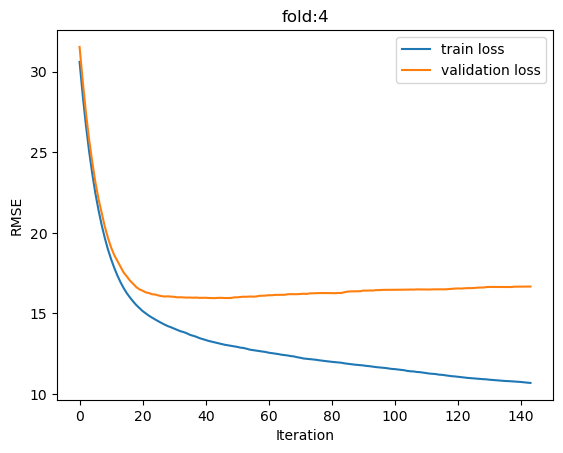

100%|██████████| 30/30 [00:00<00:00, 244.83it/s]


Fold 4:
TN  FP
FN  TP
[[201553   3503]
 [   382    441]]
Accuracy: 0.9811296926835665
Recall: 0.5358444714459295
Precision: 0.11181541582150101
F1 score : 0.18502202643171806
---------------------------------------------



In [403]:

predictions = []
lgb_models_reg = []

params = {
        'boosting_type': 'gbdt',      # GBDTを指定
        'objective': 'regression',    # 回帰を指定
        'metric': 'rmse',             # 回帰の損失（誤差）
        'seed': 123                   # シード値
        }


for fold, (train_index, val_index) in enumerate(folds.split(df_train)):
    
    train, val = df_train.iloc[train_index], df_train.iloc[val_index]
    train_y = train['speed_tomorrow']
    train_x = train.drop(['speed_tomorrow', 'is_congestion_tomorrow', 'datetime', 'weight_reg', 'tomorrow_holiday', *ignore_features_reg], axis=1)
    val_y = val['speed_tomorrow']
    val_x = val.drop(['speed_tomorrow', 'is_congestion_tomorrow', 'datetime', 'weight_reg', 'tomorrow_holiday', *ignore_features_reg], axis=1)
    
    weight_train = train['weight_reg']
    weight_val = val['weight_reg']
    
    lgb_train = lgb.Dataset(train_x, train_y, weight=weight_train)
    lgb_val = lgb.Dataset(val_x, val_y, weight=weight_val)
    
    verbose_eval = -1
    lgb_results = {}
    
    model = lgb.train(
                params,
                lgb_train,
                categorical_feature=categorical_features,
                valid_sets=[lgb_train, lgb_val],
                valid_names=['Train', 'Test'],
                num_boost_round=100000,
                callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(verbose_eval), lgb.record_evaluation(lgb_results)] ) 
    
    best_params = model.params
    
    lgb_models_reg.append(model)
    
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    
    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='validation loss')
    
    plt.legend()
    plt.show()
    
    pred_df = pd.DataFrame(columns=['datetime', 'section', 'prediction'])
    for d, input_df in tqdm(test_x_reg.groupby(test_x_reg['datetime'].dt.date)):
        input = input_df.drop('datetime', axis=1).reset_index(drop=True)
        pred = model.predict(input, num_iteration=model.best_iteration)
        preds = input_df[['datetime', 'section']].copy()
        preds['prediction'] = pred
        pred_df = pred_df.append(preds, ignore_index=True)    

    answer_df = df_test[['datetime', 'section', 'speed_tomorrow']]
    pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
    pred_df = pred_df.reset_index(drop=True)
    answer_df = pd.merge(answer_df, pred_df, on=['datetime', 'section'], how='inner')
    answer_binary = (answer_df['speed_tomorrow'] <= 40).astype(int)
    prediction_binary = (answer_df['prediction'] <= 40).astype(int)
    
    predictions.append(prediction_binary)
    
    accuracy = accuracy_score(answer_binary, prediction_binary)
    recall = recall_score(answer_binary, prediction_binary)
    precision = precision_score(answer_binary, prediction_binary)
    f1 = f1_score(answer_binary, prediction_binary)

    print(f'Fold {fold}:')
    print('TN  FP\nFN  TP')
    print(confusion_matrix(answer_binary, prediction_binary))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1 score : {f1}')
    print('---------------------------------------------\n')

In [404]:
majority_predictions = []

for i in range(len(predictions[0])):
    preds = [pred[i] for pred in predictions]
    mode = Counter(preds).most_common(1)[0][0]
    majority_predictions.append(mode)

In [405]:
sub_df = df_test[['datetime', 'start_code', 'end_code', 'KP']]
sub_df['datetime'] = pd.to_datetime(sub_df['datetime'])
sub_df['prediction'] = majority_predictions
sub_df['datetime'] += pd.to_timedelta(1, 'd')
answer_df = pd.merge(sub_df, df_test[['datetime', 'start_code', 'end_code', 'KP', 'holiday', 'is_congestion']], on=['datetime', 'start_code', 'end_code', 'KP'], how='inner')
answer_holiday_df = answer_df.loc[(answer_df['holiday'] == 1)]
answer = answer_df['is_congestion']
answer_holiday = answer_holiday_df['is_congestion']
prediction = answer_df['prediction']
prediction_holiday =answer_holiday_df['prediction']

accuracy = accuracy_score(answer, prediction)
recall = recall_score(answer, prediction)
precision = precision_score(answer, prediction)
f1 = f1_score(answer, prediction)

accuracy_holiday = accuracy_score(answer_holiday, prediction_holiday)
recall_holiday = recall_score(answer_holiday, prediction_holiday)
precision_holiday = precision_score(answer_holiday, prediction_holiday)
f1_holiday = f1_score(answer_holiday, prediction_holiday)

print('Voting:\n')
print('All days')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer, prediction))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score : {f1}')
print('\n')
print('Only holiday')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer_holiday, prediction_holiday))
print(f'Accuracy: {accuracy_holiday}')
print(f'Recall: {recall_holiday}')
print(f'Precision: {precision_holiday}')
print(f'F1 score : {f1_holiday}')

Voting:

All days
TN  FP
FN  TP
[[195689   2509]
 [   403    378]]
Accuracy: 0.9853652898044517
Recall: 0.4839948783610755
Precision: 0.1309317630758573
F1 score : 0.20610687022900764


Only holiday
TN  FP
FN  TP
[[60758   564]
 [  208   220]]
Accuracy: 0.9874979757085021
Recall: 0.514018691588785
Precision: 0.28061224489795916
F1 score : 0.36303630363036304


In [406]:
model_names = {
    0: "model_fold_0",
    1: "model_fold_1",
    2: "model_fold_2",
    3: "model_fold_3",
    4: "model_fold_4",}

save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

for fold, model in enumerate(lgb_models_reg):
    model_name = model_names.get(fold, f'model_fold_{fold}')
    with open(os.path.join(save_dir, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(model, f)

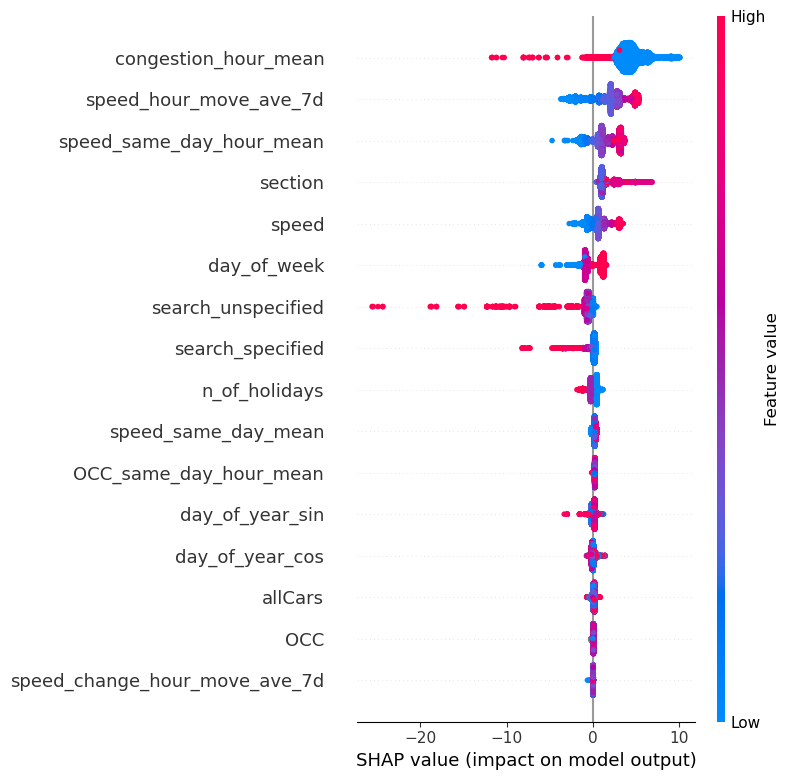

In [407]:
explainer = shap.Explainer(model=model)
shap_values = explainer.shap_values(val_x[0:10000])

shap.summary_plot(shap_values, val_x[0:10000], show=False)
plt.show()

In [408]:
shap.plots.bar(shap_values, max_display=40)
plt.show()

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [ ]:
#shap.decision_plot(explainer.expected_value, explainer.shap_values(val_x), val_x, show=False, ignore_warnings=True)
#plt.show()